In [21]:
library(ggplot2)
library(scales)
library(vcfR)
library("tidyverse")
library(gridExtra)
library(ggridges)
theme_set(theme_minimal())

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [128]:
asinh_trans <- function(){
  trans_new(name = 'asinh', transform = function(x) asinh(x), 
            inverse = function(x) sinh(x))
}
     
read_vcf <- function(vcf_file) {
    vcf <- read.vcfR( vcf_file, verbose = FALSE )  
    values = vcfR2tidy(vcf, 
          info_only = TRUE,
          info_fields = c("SVLEN", "IDLIST"),
          verbose = FALSE)  
    return(values)
}
       
read_techno <- function(df, techno, toolid) {
     technosv = df$fix %>% filter(str_detect(IDLIST, toolid))
     technodata = data.frame(as.numeric(technosv$SVLEN))
     names(technodata) = "size"
     technodata$techno = techno
     technodata$techno = as.factor(technodata$techno)
     return(technodata)
}
                
                        
dualplotmulti <- function(data, adjust=4) {
   negative = subset(data, size<0, select=c(size, techno))
   p1 = ggplot() +
               geom_density(data = negative, aes(x=size, y=..count.., color=techno), adjust=adjust, alpha=0.3, bw=0.02, fill=NA) +
               #coord_cartesian(ylim=c(0, 10000)) +
               theme_bw() +
               scale_x_continuous(limits=c(-100000,-50), 
                                  breaks=c(-100000,-10000,-100, -50),
                                  label=c('-100kb','-10kb','-100bp',''),
                                  trans="asinh",
                                  expand = expansion(add = 0.1)) + 
               theme(plot.margin = unit(c(1,0,1,1), "cm")) +
               scale_y_continuous(position = "left",  breaks=c(5000,10000), labels=c(200, 400)) + 
               theme(legend.position = "none")
   positive = subset(data, size>0, select=c(size, techno))
   p2 = ggplot() +
            geom_density(data = positive, aes(x=size, y=..count.., color=techno), adjust=adjust, alpha=0.3, bw=0.02, fill=NA) +
            #coord_cartesian(ylim=c(0, 10000)) +
            theme_bw() +
            scale_x_continuous(limits=c(50,100000), 
                                breaks=c(50, 100, 10000, 100000),
                                label=c('', '100bp','10kb','100kb'),
                                trans="asinh",
                                expand = expansion(add = 0.1)) + 
            theme(plot.margin = unit(c(1,1,1,0), "cm"))  +
            #guides(colour = guide_legend(override.aes = list(alpha = 1)))
            scale_y_continuous(position = "right",  breaks=c(5000,10000), labels=c(200, 400))
    return(list("left"=p1, "right"=p2))
}              

In [117]:
vcffile="testdata/test.vcf.gz"
df = read_vcf(vcffile)

In [118]:
head(df$fix,n=4)

CHROM POS ID           REF
1 1     131 1_CLR.INS.72 C  
2 1     312 1_CLR.INS.73 G  
3 1     319 1_CLR.INS.74 T  
4 1     339 1_CLR.INS.75 T  
  ALT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [119]:
illumina = read_techno(df, "illumina", "Manta")
CLR = read_techno(df, "CLR", "CLR")
HiFi = read_techno(df, "HiFi", "HiFi")
ONT = read_techno(df, "ONT", "svim")
assembly = read_techno(df, "assembly", "paftools")
data = rbind(illumina, HiFi, CLR, ONT, assembly)

Warning message:
“Removed 202 rows containing non-finite values (stat_density).”
Warning message:
“Removed 170 rows containing non-finite values (stat_density).”


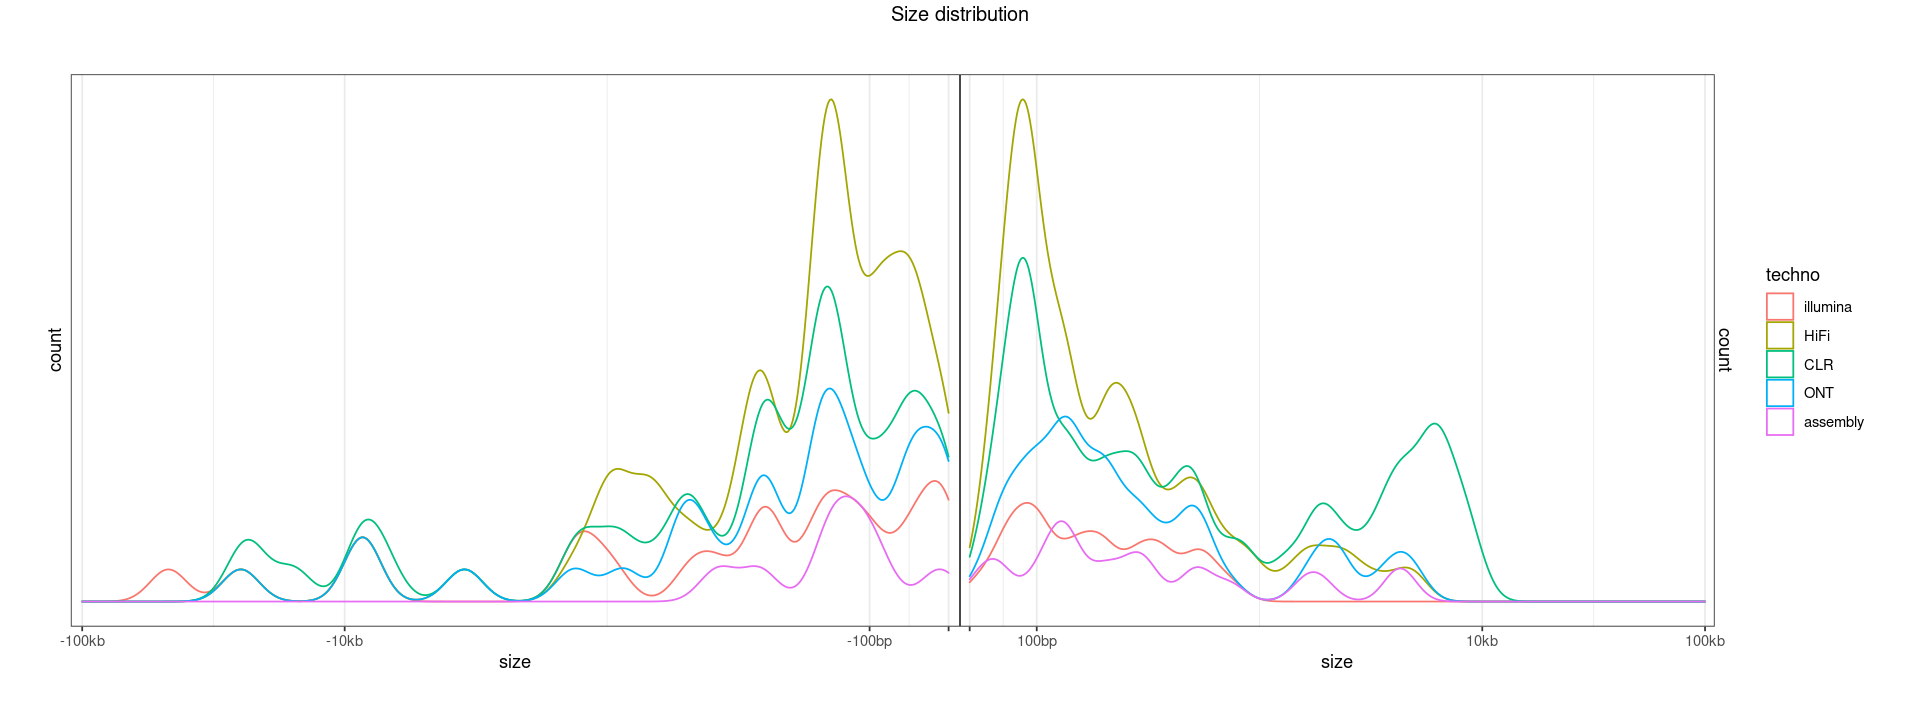

In [131]:
# adjust is a "multiplicate bandwidth adjustment" see https://ggplot2.tidyverse.org/reference/geom_density.html
g = dualplotmulti(data, adjust=8)
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(g$left, g$right, ncol=2, top = "Size distribution")